### CP Solver, 1 game a day on weekdays, 2 on weekends

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [76]:
number_games = 45 
number_days = 36
game_values = np.random.randint(10, size=(number_games,number_days))

In [45]:
#modifying  game_values so that there is same value for weekdays/weekends, which is different from weekends/weekdays
for i in range(len(game_values)):
    wnd = max(game_values[i]) + np.random.randint(-1, 2)
    wkd = np.mean(game_values[i]) + np.random.randint(-2,3)
    for j in range(len(game_values[0])):
        if j%7 <= 4:
            game_values[i,j] = wkd
        else:
            game_values[i,j] = wnd
            

In [46]:
game_costs = pd.DataFrame(game_values, columns = range(game_values.shape[1]), index= range(game_values.shape[0]))

In [56]:
from ortools.sat.python import cp_model

# we will replace workers with games and tasks with days

def main():
    # Data
    """costs = [
        [90, 80, 75, 70],
        [35, 85, 55, 65],
        [125, 95, 90, 95],
        [45, 110, 95, 115],
        [50, 100, 90, 100],
    ]"""
    
    """costs = [
        [10,10,10,10,10,20],
        [20,20,20,20,20,30],
        [40,40,40,40,40,45],
        [50,50,50,50,50,50],
        [10,10,10,10,10,30],
        [10,10,10,10,10,25],
        [10,10,10,10,10,15]
        
    ]"""
    
    costs = game_values
    
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Model
    model = cp_model.CpModel()

    # Variables
    x = []
    for i in range(num_workers):
        t = []
        for j in range(num_tasks):
            t.append(model.NewBoolVar('x[%i,%i]' % (i, j)))
        x.append(t)

    # Constraints
    # Each worker/game is assigned to at most one task/day.
    for i in range(num_workers):
        model.Add(sum(x[i][j] for j in range(num_tasks)) <= 1)

    # Each task/day is assigned to exactly one worker/game on weekdays. on weekends, there can be 2 games per day
    for j in range(num_tasks):
        if j%7 <= 4:
            model.Add(sum(x[i][j] for i in range(num_workers)) == 1)
        else:
            model.Add(sum(x[i][j] for i in range(num_workers)) == 2)

    # Objective 
    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i][j])
    model.Maximize(sum(objective_terms))

    # Solve
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    
    
    # Print solution.
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print('Total cost = %i' % solver.ObjectiveValue())
        print()
        for i in range(num_workers):
            for j in range(num_tasks):
                if solver.BooleanValue(x[i][j]):
                    print('Game ', i, ' assigned to day ', j, '  Cost = ',
                          costs[i][j])
        soln_matrix = pd.DataFrame(x).applymap(solver.BooleanValue) # creating and returning the solution in grid / matrix form
        return(soln_matrix)
    else:
        print('No solution found.')
    

if __name__ == '__main__':
    soln = main()

Total cost = 318

Game  0  assigned to day  20   Cost =  10
Game  1  assigned to day  5   Cost =  9
Game  2  assigned to day  17   Cost =  6
Game  3  assigned to day  12   Cost =  8
Game  4  assigned to day  21   Cost =  6
Game  5  assigned to day  11   Cost =  7
Game  6  assigned to day  28   Cost =  6
Game  7  assigned to day  33   Cost =  8
Game  8  assigned to day  2   Cost =  6
Game  9  assigned to day  16   Cost =  6
Game  10  assigned to day  24   Cost =  5
Game  11  assigned to day  22   Cost =  6
Game  12  assigned to day  25   Cost =  5
Game  13  assigned to day  27   Cost =  10
Game  14  assigned to day  7   Cost =  5
Game  15  assigned to day  1   Cost =  6
Game  16  assigned to day  6   Cost =  10
Game  17  assigned to day  34   Cost =  10
Game  18  assigned to day  29   Cost =  5
Game  19  assigned to day  26   Cost =  10
Game  20  assigned to day  6   Cost =  8
Game  21  assigned to day  19   Cost =  9
Game  22  assigned to day  9   Cost =  5
Game  23  assigned to day  3

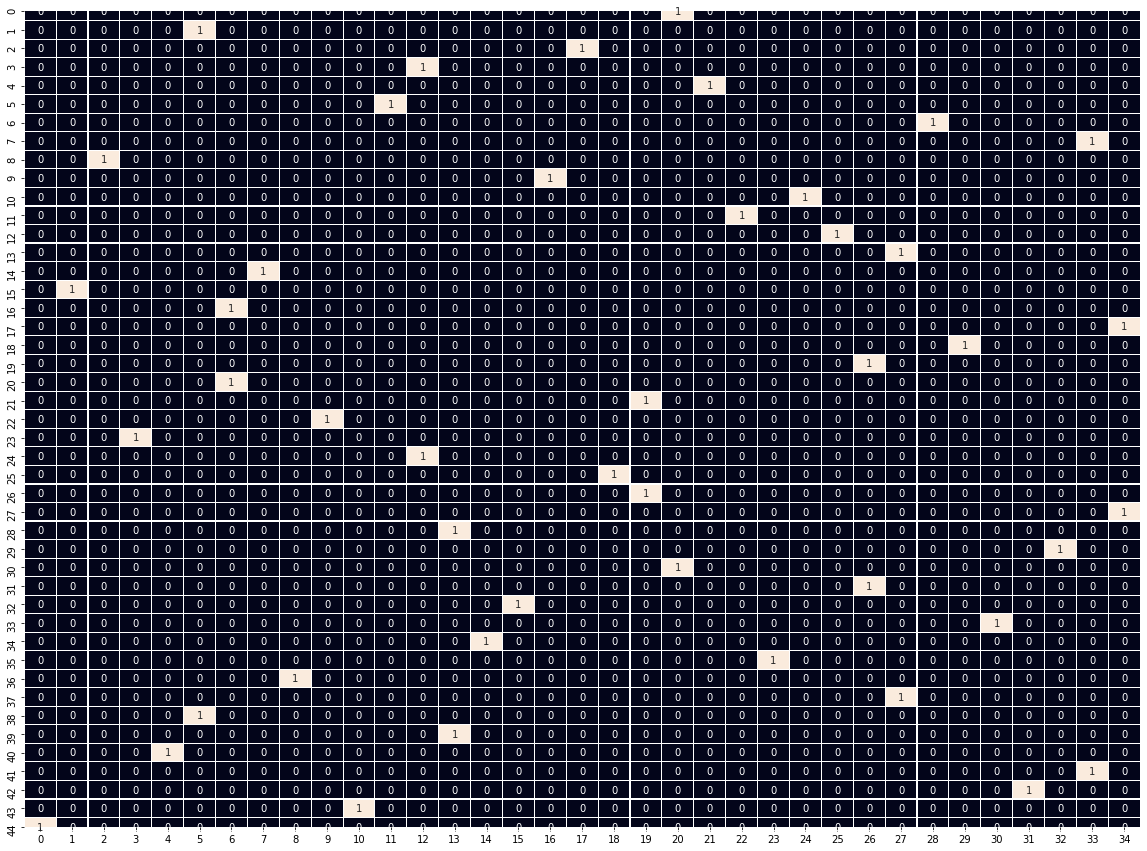

In [75]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(soln, linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)

In [74]:
game_costs

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,5,5,5,5,5,10,10,5,5,5,...,5,10,10,5,5,5,5,5,10,10
1,4,4,4,4,4,9,9,4,4,4,...,4,9,9,4,4,4,4,4,9,9
2,6,6,6,6,6,8,8,6,6,6,...,6,8,8,6,6,6,6,6,8,8
3,3,3,3,3,3,8,8,3,3,3,...,3,8,8,3,3,3,3,3,8,8
4,6,6,6,6,6,9,9,6,6,6,...,6,9,9,6,6,6,6,6,9,9
5,7,7,7,7,7,10,10,7,7,7,...,7,10,10,7,7,7,7,7,10,10
6,6,6,6,6,6,8,8,6,6,6,...,6,8,8,6,6,6,6,6,8,8
7,2,2,2,2,2,8,8,2,2,2,...,2,8,8,2,2,2,2,2,8,8
8,6,6,6,6,6,8,8,6,6,6,...,6,8,8,6,6,6,6,6,8,8
9,6,6,6,6,6,10,10,6,6,6,...,6,10,10,6,6,6,6,6,10,10


### MIP Solver, 1 game a day

In [3]:
from ortools.linear_solver import pywraplp


def main():
    # Data
    costs = [
        [90, 80, 75, 70],
        [35, 85, 55, 65],
        [125, 95, 90, 95],
        [45, 110, 95, 115],
        [50, 100, 90, 100],
    ]
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Solver
    # Create the mip solver with the CBC backend.
    solver = pywraplp.Solver.CreateSolver('assignment_mip', 'CBC')


    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = solver.IntVar(0, 1, '')

    # Constraints
    # Each worker is assigned to at most 1 task.
    for i in range(num_workers):
        solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) <= 1)

    # Each task is assigned to exactly one worker.
    for j in range(num_tasks):
        solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == 1)

    # Objective
    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()

    # Print solution.
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print('Total cost = ', solver.Objective().Value(), '\n')
        for i in range(num_workers):
            for j in range(num_tasks):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i, j].solution_value() > 0.5:
                    print('Worker %d assigned to task %d.  Cost = %d' %
                          (i, j, costs[i][j]))


if __name__ == '__main__':
    main()

AttributeError: type object 'Solver' has no attribute 'CreateSolver'